### Load data into dataframe

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.utils import column_or_1d
data = pd.read_csv('dane_dm/spam.dat', delimiter=',')
x_data = data.loc[:, data.columns != 'target']
target_data = column_or_1d(data.loc[:, data.columns == 'target'])
print(x_data)
print(target_data)

      ACT_NOW  ADDRESSES_ON_CD  ADULT_SITE  ADVERT_CODE  ADVERT_CODE2  \
0           0                0           0            0             0   
1           0                0           0            0             0   
2           0                0           0            0             0   
3           0                0           0            0             0   
4           0                0           0            0             0   
5           0                0           0            0             0   
6           0                0           0            0             0   
7           0                0           0            0             0   
8           0                0           0            0             0   
9           0                0           0            0             0   
10          0                0           0            0             0   
11          0                0           0            0             0   
12          0                0           0         

### Feature selection
Number of features in processed data is quite high. Probably only a part of them is usefull in a case of spam classification. To avoid unnecessary large amount of data processing I am going to extract 100 *best* features and use only them in a classifier.

In [2]:
from sklearn.feature_selection import SelectKBest, chi2
print(x_data.shape)

(4789, 462)


In [3]:
x_k_best_chi = SelectKBest(chi2, k=100).fit_transform(x_data, target_data)
print(x_k_best_chi.shape)

(4789, 100)


### Classification

#### Cross validation
Since learning and testing using the same data is a mistake (because it makes classifiers useless with new data) I am using a cross-validation (CV). 
CV splits my training dataset into smaller sets (*k* sets) and then a model is trained with *k-1* sets and tested with the remaining one. This procedure repeats k times (for each iteration we are changing the testing set).

#### Classification
##### Decision Tree Classifier

In [4]:
from sklearn.tree import DecisionTreeClassifier

predictions = {}

dct_classifier = DecisionTreeClassifier(class_weight={'yes': 0.001, 'no': 20})
# scores = cross_val_score(dct_classifier, x_k_best_chi, target_data, cv=10)
# print(scores)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
prediction = cross_val_predict(dct_classifier, x_k_best_chi, target_data, cv=10)
predictions['Decision Tree'] = prediction

##### Multinomial Naive Bayes Classifier

In [5]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB(class_prior=[0.1, 0.9])
# scores = cross_val_score(nb_classifier, x_k_best_chi, target_data, cv=10)
# print(scores)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
prediction = cross_val_predict(nb_classifier, x_k_best_chi, target_data, cv=10)
predictions['Multinomial Naive Bayes'] = prediction

##### Support Vector Machine Classifier

In [6]:
from sklearn import svm

svm_classifier = svm.SVC(gamma='scale')
# scores = cross_val_score(svm_classifier, x_k_best_chi, target_data, cv=10)
# print(scores)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
prediction = cross_val_predict(svm_classifier, x_k_best_chi, target_data, cv=10)
predictions['Support Vector Machines'] = prediction

##### MLP Classifier (Neural Network)

In [7]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(solver='lbfgs')
prediction = cross_val_predict(mlp_classifier, x_k_best_chi, target_data, cv=10)
predictions['MLP Neural Network'] = prediction

#### Measures
##### Accuracy
We can evaluate classifier using accuracy measure. By definition it is:
```math
number_of_correct_predictions / total_number_of_predictions
```
But this measure is not suitable in case of dealing with uneven class distribution and when we are trying to minimalize *false negative* or *false positive* results.

That is why confusion matrix is a better solution.

##### Confusion Matrix

Confusion matrix represents *true positive*, *true negative*, *false negative* and *false positive* results. 

Confusion matrix, without normalization
[[2914   35]
 [  71 1769]]


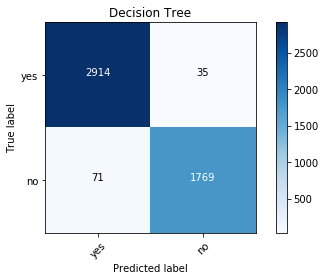

Confusion matrix, without normalization
[[2648  301]
 [  29 1811]]


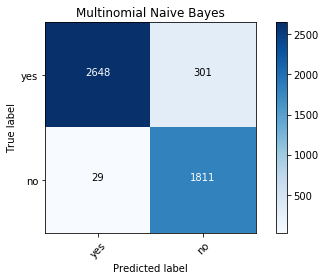

Confusion matrix, without normalization
[[2927   22]
 [  82 1758]]


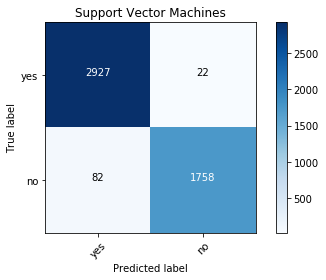

Confusion matrix, without normalization
[[2917   32]
 [  74 1766]]


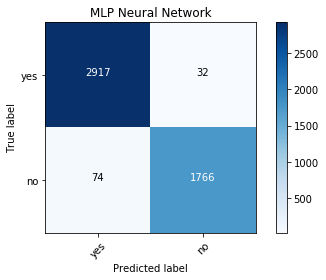

In [9]:
# Confusion matrix code from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

class_names = ['yes', 'no']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def show_confusion_matrix(y_test, y_pred, method_title):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                          title=method_title)

    plt.show()

for k, p in predictions.items():
    show_confusion_matrix(target_data, p, k)

##### Results
Result presented above shows that without any special customisation all methods (Decision Tree, SVM, MLP NN, NB) give similar results. 
Also, there are 1.5%-2% of *false positive* results. In case of spam detection we would like to minimalize this rate.
In order to achive that we could use *weights* to improve classifier.

For Multinomial Naive Bayes Classifier *class_weight* parameter helped us to achive better (lower) *false positive* rate. But we should notice, that it also caused higher *false negative* rate.

##### PCA
PCA decreases number of data dimentions.
In this case I tried creating 2 principal components and then visualized the results.

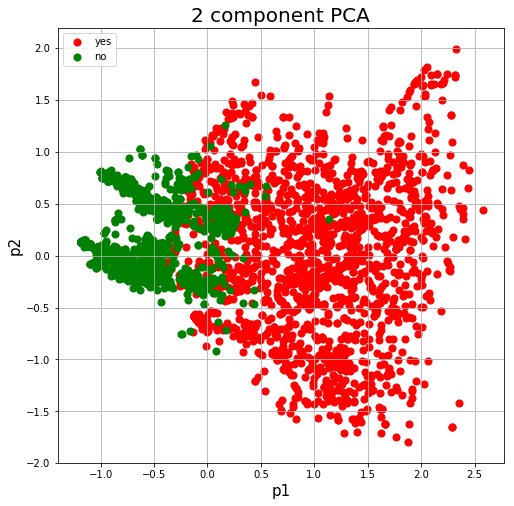

In [23]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=2)
principal_components = pca.fit(x_data)
pca_components = pca.fit_transform(x_data)
principal_df = pd.DataFrame(data=pca_components, columns=['p1', 'p2'])

final_df = pd.concat([principal_df, data[['target']]], axis=1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('p1', fontsize = 15)
ax.set_ylabel('p2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['yes', 'no']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['target'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'p1']
               , final_df.loc[indicesToKeep, 'p2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


As we can see on the picture above we can separate data into dwo groups:
* with spam (red)
* without spam (green)

We can see maxiumum variance of each feaure in components *p1* and *p2*:

In [38]:
components = pd.DataFrame(principal_components.components_,columns=x_data.columns,index = ['p1','p2'])
new_compoennts = components[(components>0.2) | (components<-0.2)]
print(new_compoennts.T[(new_compoennts.T['p1'] > 0.2) | (new_compoennts.T['p2'] > 0.2) | (new_compoennts.T['p1'] < -0.2) | (new_compoennts.T['p1'] < -0.2)])

                         p1        p2
BIG_FONT           0.219292       NaN
CLICK_BELOW        0.369991       NaN
CLICK_HERE_LINK    0.244888       NaN
CTYPE_JUST_HTML    0.255540       NaN
NO_REAL_NAME            NaN  0.293615
RESENT_TO               NaN  0.200280
SPAM_PHRASE_00_01 -0.458831       NaN
X_AUTH_WARNING          NaN  0.619622


Maxium variance shows that there are couple of features that indicates that email is a spam:
* using big font, coaxing to click a link
* peculiar data in headers that indicate that email was not sent by a regular user

Based on mentioned featureswe could create a new classificator.